In [7]:
! pip install jraph

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 6.2 MB/s eta 0:00:00


In [8]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf
from models.diffusion_utils import sigma2
import diffrax as dfx

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, train_step
from datasets import load_data

EPS = 1e-7

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from matplotlib import cm
cmap = cm.get_cmap('viridis_r')

import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

# warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

import logging
import matplotlib

logging.getLogger('matplotlib').setLevel(logging.ERROR)

/tmp/ipykernel_2832855/4193622703.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis_r')


## Dirs

In [11]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"

## My new runs
logging_dir = "/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-checkpoints/cosmology/"
run_name = "gallant-cherry-87"

## Load cluster run

In [12]:
config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [13]:
# Load the dataset
train_ds, norm_dict = load_data(
        config.data.dataset,
        config.data.n_features,
        config.data.n_particles,
        64,
        config.seed,
        shuffle=True,
        split="test",
    )

batches = create_input_iter(train_ds)

In [14]:
x, conditioning, mask = next(batches)
x = x.reshape(-1, config.data.n_particles, config.data.n_features)
conditioning = conditioning.reshape(-1, 2)
mask = mask.reshape(-1, config.data.n_particles)

In [15]:
# Diffusion model
x_mean = tuple(map(float, norm_dict["mean"]))
x_std = tuple(map(float, norm_dict["std"]))
config.data.apply_pbcs = False
box_size = config.data.box_size #if config.data.apply_pbcs else None
unit_cell = tuple(map(tuple, config.data.unit_cell)) if config.data.apply_pbcs else None

norm_dict_input = FrozenDict(
    {
        "x_mean": x_mean,
        "x_std": x_std,
        "box_size": box_size,
        "unit_cell": unit_cell,
    }
)

In [16]:
print("{} devices visible".format(jax.device_count()))

# Score and (optional) encoder model configs
score_dict = FrozenDict(config.score)
encoder_dict = FrozenDict(config.encoder)
decoder_dict = FrozenDict(config.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(
        d_feature=config.data.n_features,
        timesteps=config.vdm.timesteps,
        noise_schedule=config.vdm.noise_schedule,
        noise_scale=config.vdm.noise_scale,
        d_t_embedding=config.vdm.d_t_embedding,
        gamma_min=config.vdm.gamma_min,
        gamma_max=config.vdm.gamma_max,
        score=config.score.score,
        score_dict=score_dict,
        embed_context=config.vdm.embed_context,
        d_context_embedding=config.vdm.d_context_embedding,
        n_classes=config.vdm.n_classes,
        use_encdec=config.vdm.use_encdec,
        encoder_dict=encoder_dict,
        decoder_dict=decoder_dict,
        norm_dict=norm_dict_input,
)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
if hasattr(config.optim, "grad_clip"):
    if config.optim.grad_clip is not None:
        tx = optax.chain(
            optax.clip(config.optim.grad_clip),
            tx,
        )

state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

1 devices visible
Params: 637,373


In [17]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state, step=295000)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

## Vary cosmologies

In [24]:
from tqdm import tqdm

In [20]:
from einops import repeat

n_lin = 9 * 2

conditioning_mean = np.mean(conditioning, axis=0)
conditioning_batch = repeat(conditioning_mean, "c -> c n", n=n_lin)

In [21]:
conditioning_batch = conditioning_batch.at[-1, :int(n_lin / 2)].set(0.6)
conditioning_batch = conditioning_batch.at[0, :int(n_lin / 2)].set(np.linspace(0.1, 0.5, int(n_lin / 2)))
conditioning_batch = conditioning_batch.at[0, int(n_lin / 2):].set(0.5)
conditioning_batch = conditioning_batch.at[-1, int(n_lin / 2):].set(np.linspace(0.6, 1., int(n_lin / 2))).T

conditioning_batch = np.concatenate([conditioning_batch, conditioning_batch[::-1]])

In [22]:
conditioning_batch = conditioning_batch.at[n_lin:, -1].set(1.)
conditioning_batch = conditioning_batch.at[n_lin:n_lin + int(n_lin / 2), 0].set(np.linspace(0.5, 0.1, int(n_lin / 2)))
conditioning_batch = conditioning_batch.at[n_lin + int(n_lin / 2):, 0].set(0.1)
conditioning_batch = conditioning_batch.at[n_lin + int(n_lin / 2):, -1].set(np.linspace(1., 0.6, int(n_lin / 2)))

In [27]:
x_samples_cond = [generate(vdm, restored_state.params, rng, (1, config.data.n_particles), conditioning=conditioning_batch[i][None, :], mask=mask[0][None, :], steps=1000) for i in tqdm(range(n_lin * 2))]
x_samples_cond = np.array([xx.mean()[0] for xx in x_samples_cond])



  0%|                                                                                        | 0/36 [00:56<?, ?it/s]


  3%|██▏                                                                             | 1/36 [00:21<12:16, 21.05s/it]

  6%|████▍                                                                           | 2/36 [00:40<11:27, 20.22s/it]

  8%|██████▋                                                                         | 3/36 [01:00<10:58, 19.97s/it]

 11%|████████▉                                                                       | 4/36 [01:20<10:38, 19.94s/it]

 14%|███████████                                                                     | 5/36 [01:39<10:14, 19.83s/it]

 17%|█████████████▎                                                                  | 6/36 [01:59<09:56, 19.89s/it]

 19%|███████████████▌                                                                | 7/36 [02:19<09:34, 19.82s/it]

 22%|█████████████████▊                              

In [28]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib

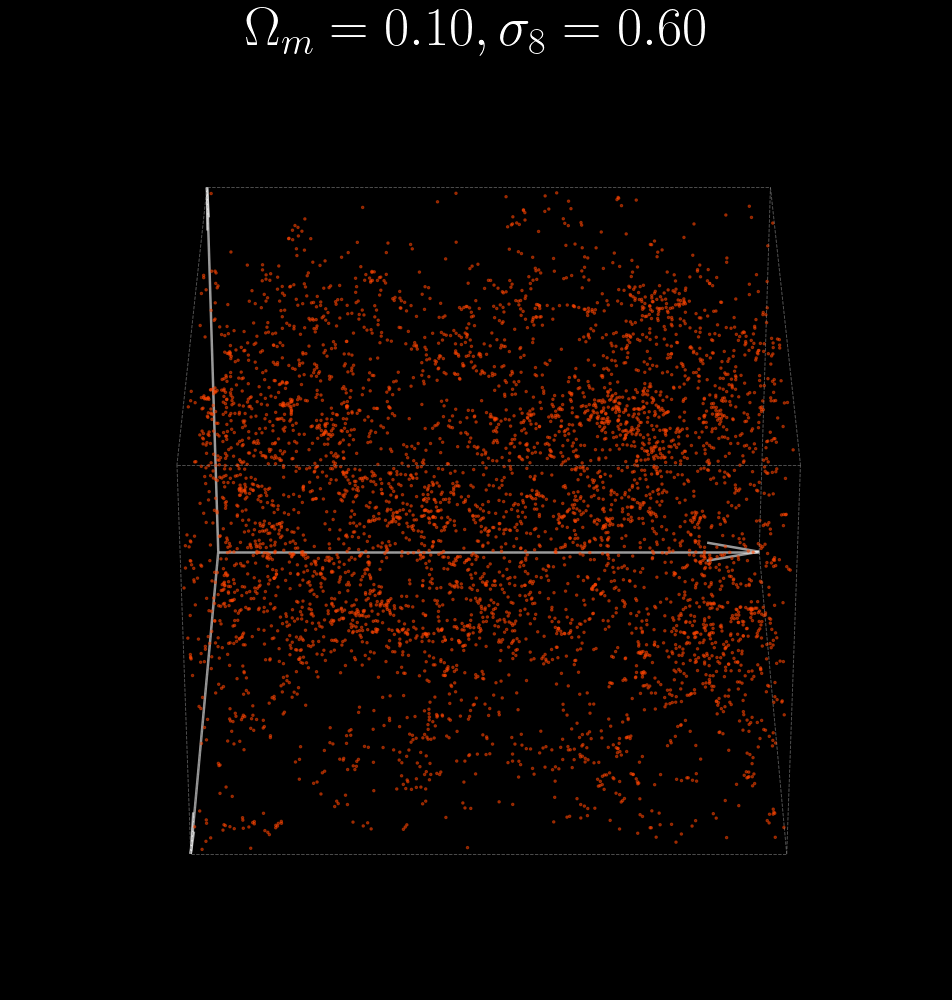

In [57]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(18, 14))

ax2 = fig.add_subplot(1, 1, 1, projection='3d')

def update(frame, idx_array, angle_array, rotate=True):
    
    # ax1.clear()
    ax2.clear()
    
    ii = idx_array[frame]
    
    if rotate:
        ax2.view_init(30, angle_array[frame])
    
    x_plot = x_samples_cond[ii] * np.array(x_std) + np.array(x_mean)
    ax2.scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.5, s=6, color="orangered");
    
    ax2.set_title(r"$\Omega_m = {:.2f}, \sigma_8 = {:.2f}$".format(round(conditioning_batch[ii, 0], 2), round(conditioning_batch[ii, -1], 2)), fontsize=55)
    
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("z")
    
    ax2.set_axis_off()
    
    xx, yy, zz = np.zeros((3,3))
    uu, vv, ww = 1000 * np.array([[1,0,0],[0,1,0],[0,0,1]])

    ax2.quiver(xx,yy,zz,uu,vv,ww,arrow_length_ratio=0.1, color='white', alpha=0.6)


    box_color = 'grey'
    box_ls = '--'
    box_alpha = 0.4
    box_lw = 0.9
    
    r = np.array([0, 1000])
    X, Y = np.meshgrid(r, r)
    Z = np.array(r)
    
    # Re-creating the 2D arrays for Z component to match the shape of X and Y for the top and bottom surfaces
    Z_bottom = np.zeros_like(X)
    Z_top = np.ones_like(X) * Z[1]
    
    # Bottom surface
    ax2.plot_wireframe(X, Y, Z_bottom, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    # Top surface
    ax2.plot_wireframe(X, Y, Z_top, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    # Sides
    ax2.plot_wireframe(X, np.full_like(X, Z[0]), Y, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    ax2.plot_wireframe(X, np.full_like(X, Z[1]), Y, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    ax2.plot_wireframe(np.full_like(Y, Z[0]), Y, X, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    ax2.plot_wireframe(np.full_like(Y, Z[1]), Y, X, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)

    ax2.set_xlim(0, 1000)
    ax2.set_ylim(0, 1000)
    ax2.set_zlim(0, 1000)

    plt.tight_layout()


array = np.arange(len(conditioning_batch))
index = 0
increment = 1

n_frames = 4 * len(conditioning_batch)  # 10 breaths

idx_array = []
for i in range(n_frames):
    idx_array.append(array[index])
    
    if index == len(array) - 1:
        increment = -1
    elif index == 0:
        increment = 1
        
    index += increment
    
idx_array = np.array(idx_array)
idx_array = np.concatenate([idx_array, np.arange(idx_array[-1], 0, -1)])
angle_array = np.linspace(0, 360, len(idx_array))

rotate = True

ani = animation.FuncAnimation(fig, partial(update, idx_array=idx_array, angle_array=angle_array, rotate=rotate) , frames=len(idx_array), interval=100)
ani.save("animations/animation_both.gif", writer="imagemagick")

In [45]:
def generate_t(vdm, params, rng, shape, conditioning=None, mask=None, steps=None, sample_substeps=None):
    """Generate samples from a VDM model."""

    if sample_substeps is None:
        sample_substeps = steps
        
    # Generate latents
    rng, spl = jax.random.split(rng)

    # If using a latent projection, use embedding size; otherwise, use feature size
    zt = jax.random.normal(spl, shape + (vdm.encdec_dict["d_embedding"] if vdm.use_encdec else vdm.d_feature,))
    if vdm.timesteps == 0:
        if steps is None:
            raise Exception("Need to specify steps argument for continuous-time VLB")
        else:
            timesteps = steps
    else:
        timesteps = vdm.timesteps

    def body_fn(i, z_t):
        return vdm.apply(params, rng, i, timesteps, z_t, conditioning, mask=mask, method=vdm.sample_step)

    z0 = jax.lax.fori_loop(lower=0, upper=sample_substeps, body_fun=body_fn, init_val=zt)

    g0 = vdm.apply(params, 0.0, method=vdm.gammat)
    var0 = sigma2(g0)
    z0_rescaled = z0 / np.sqrt(1.0 - var0)
    return vdm.apply(params, z0_rescaled, conditioning, method=vdm.decode)

In [49]:
t_ary = np.linspace(0, 1, 50)

In [51]:
n_samples = 1

cond_gen = conditioning[0]
mask_gen = mask[0]

t_ary = np.linspace(0, 1, 50)

x_sample_seq_sde = [generate_t(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), 
                           conditioning=conditioning_batch[0][None, :], mask=mask_gen[None, ...], steps=1000, sample_substeps=int(t0 * 1000)).mean()[0] for t0 in tqdm(t_ary)]


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [10:38<00:00, 12.77s/it]


In [52]:
x_sample_seq_sde = np.array(x_sample_seq_sde)

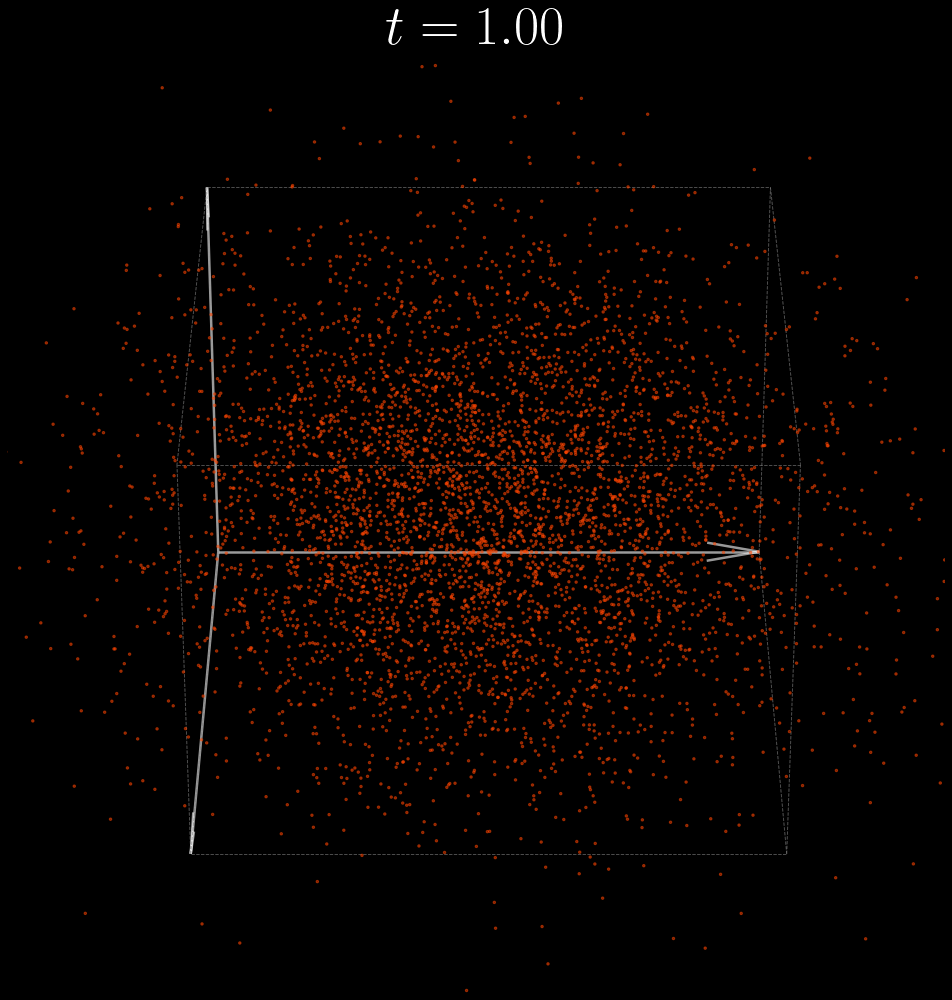

In [56]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(18, 14))

ax2 = fig.add_subplot(1, 1, 1, projection='3d')

def update(frame, idx_array, angle_array, rotate=True):
    
    ax2.clear()
    
    ii = idx_array[frame]
    
    if rotate:
        ax2.view_init(30, angle_array[frame])
    else:
        ax2.view_init(30, angle_array[0])

    
    x_plot = x_sample_seq_sde[ii] * np.array(x_std) + np.array(x_mean)
    ax2.scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.5, s=6, color="orangered");
    
    ax2.set_title(r"$t = {:.2f}$".format(1 - round(t_ary[ii], 2)), fontsize=55)
    
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("z")
    
    ax2.set_axis_off()
    
    xx, yy, zz = np.zeros((3,3))
    uu, vv, ww = 1000 * np.array([[1,0,0],[0,1,0],[0,0,1]])

    ax2.quiver(xx,yy,zz,uu,vv,ww,arrow_length_ratio=0.1, color='white', alpha=0.6)


    box_color = 'grey'
    box_ls = '--'
    box_alpha = 0.4
    box_lw = 0.9
    
    r = np.array([0, 1000])
    X, Y = np.meshgrid(r, r)
    Z = np.array(r)
    
    # Re-creating the 2D arrays for Z component to match the shape of X and Y for the top and bottom surfaces
    Z_bottom = np.zeros_like(X)
    Z_top = np.ones_like(X) * Z[1]
    
    # Bottom surface
    ax2.plot_wireframe(X, Y, Z_bottom, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    # Top surface
    ax2.plot_wireframe(X, Y, Z_top, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    # Sides
    ax2.plot_wireframe(X, np.full_like(X, Z[0]), Y, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    ax2.plot_wireframe(X, np.full_like(X, Z[1]), Y, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    ax2.plot_wireframe(np.full_like(Y, Z[0]), Y, X, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    ax2.plot_wireframe(np.full_like(Y, Z[1]), Y, X, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)

    ax2.set_xlim(0, 1000)
    ax2.set_ylim(0, 1000)
    ax2.set_zlim(0, 1000)

    plt.tight_layout()


idx_array = np.arange(len(t_ary))
angle_array = np.linspace(0, 360, len(idx_array))

rotate = False

ani = animation.FuncAnimation(fig, partial(update, idx_array=idx_array, angle_array=angle_array, rotate=rotate) , frames=len(idx_array), interval=100)
ani.save("animations/animation_diff.gif", writer="imagemagick")

In [58]:
! convert -delay 1 -loop 0 animations/animation_diff.gif animations/animation_both.gif animations/combined.gif